### Example notebook of seeding a single topic
 1. In the scenario where we are only interested in one cell type, and have obtained a high quality marker set, we can use the example presented here to annotate only the targeted cell type.
 2. We will create a new seeding list:
    - seed topic 0 with the markers of the target cell type
    - seed other topics using marker genes derive from leiden clusters, excluding the markers in topic 0

The methods can be easily extended to flexible numbers of target cell types. 

In [1]:
import warnings
warnings.filterwarnings("ignore")
import os, json
import pandas as pd
import anndata as ad
import scanpy as sc
import squidpy as sq
import numpy as np
from subprocess import call
from collections import defaultdict
from scipy.special import softmax
from pprint import pprint
from sklearn.metrics import (adjusted_mutual_info_score, adjusted_rand_score)
from seededntm import compute_tfidf_rep, compute_topic_prior
from sklearn.metrics import average_precision_score, roc_auc_score

sc.logging.print_header()
print(f"squidpy=={sq.__version__}")
target_celltype = 'Dentate_gyrus'
TOPIC_SEEDS_PATH = './topic_seeds.txt'
TARGET_TOPIC_SEEDS_PATH = f'./topic_seeds_{target_celltype}'

squidpy==1.7.0


In [2]:
adata = sq.datasets.visium_fluo_adata()
adata.X = adata.raw.X.copy() # we model count data for this demo
adata = adata[:, adata.var.highly_variable]
adata.raw = None
sc.pp.pca(adata, 100, key_added='rna_pca')
sc.pp.neighbors(adata, n_pcs=100, use_rep='rna_pca')
sc.tl.leiden(adata, resolution=1.0, random_state=0, key_added='new_leiden')
adata

AnnData object with n_obs × n_vars = 2800 × 4000
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT', 'log1p_total_counts_MT', 'pct_counts_MT', 'n_counts', 'leiden', 'cluster', 'new_leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'MT', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cluster_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'spatial', 'umap', 'rna_pca', 'new_leiden'
    obsm: 'X_pca', 'X_umap', 'spatial', 'rna_pca'
    varm: 'PCs', 'rna_pca'
    obsp: 'connectivities', 'distances'

>We focus on rare celltypes, here, the target is Dentate_gyrus cell type, which has the minimum number of cells in the dataset

In [3]:
adata.obs.cluster.value_counts()

cluster
Cortex_1             347
Cortex_2             267
Hippocampus          259
Thalamus_1           259
Fiber_tracts         245
Cortex_3             232
Cortex_4             229
Hypothalamus_1       223
Cortex_5             184
Hypothalamus_2       179
Amygdala             144
Striatum              75
Thalamus_2            73
Lateral_ventricle     47
Dentate_gyrus         37
Name: count, dtype: int64

> Rank markers for leiden clusters

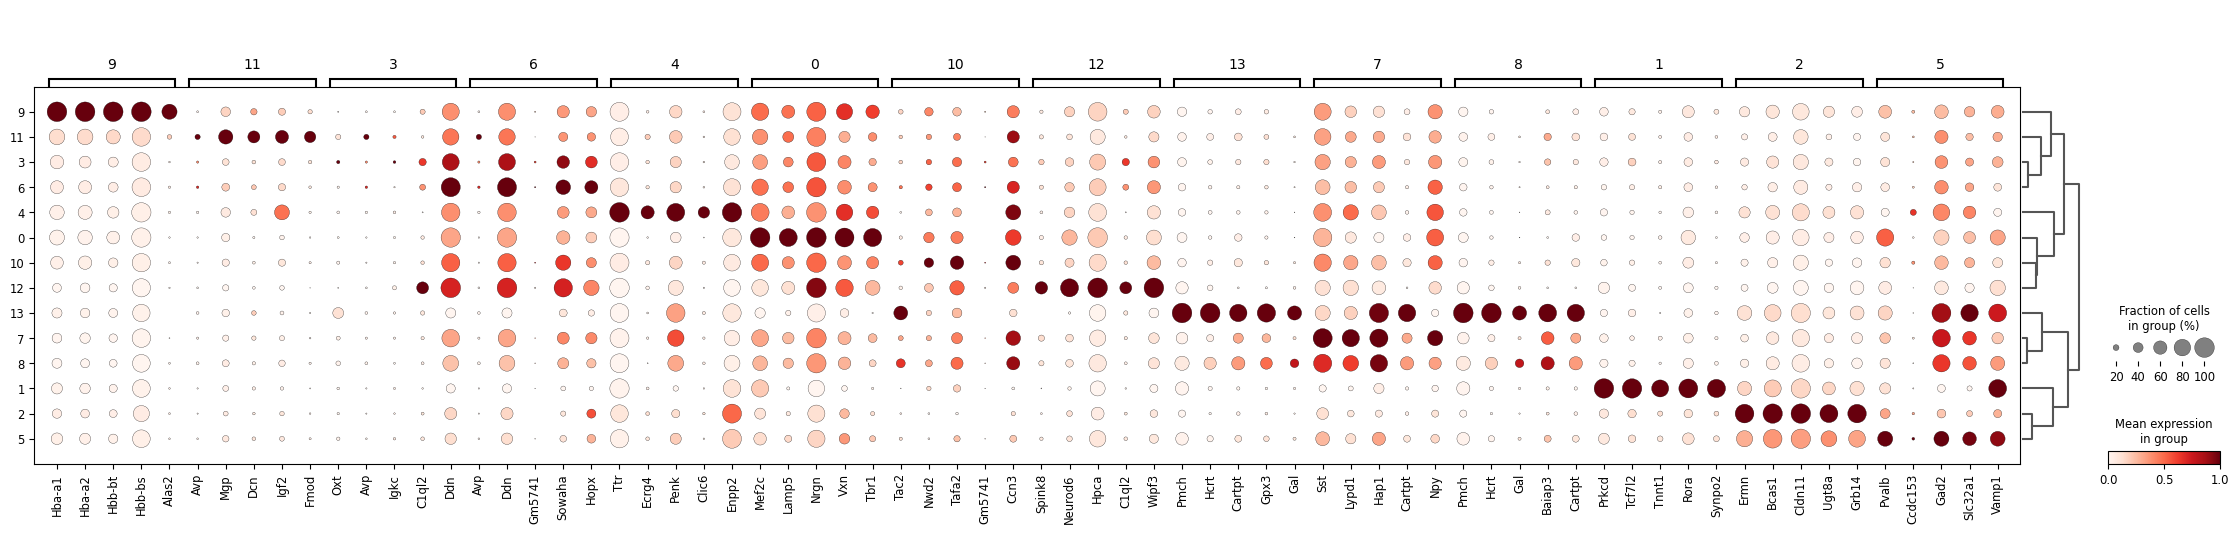

In [4]:
adata.obsm['rna_count'] = adata.X.copy()
adata.obsm['tfidf_pca'] = compute_tfidf_rep(adata.X, n_pcs=100)

adata.X = compute_tfidf_rep(adata.X, n_pcs=None).tocsr()
sc.tl.rank_genes_groups(adata, groupby='new_leiden', method="logreg", key_added='new_leiden_group', random_state=42, max_iter=800, use_raw=False)
sc.pl.rank_genes_groups_dotplot(
    adata, groupby="new_leiden", standard_scale="var", n_genes=5, key='new_leiden_group'
)
adata.X = adata.obsm['rna_count'].copy()

> Fetch the top-10 markers from the seeding gene list for Dentate_gyrus.

In [5]:
with open(TOPIC_SEEDS_PATH, 'r') as ifile:
    target_seeds = json.load(ifile)[target_celltype]['features'][:10]

> Find top-20 markers for each of the leiden cluster, excluding gene markers of the target cell type

In [6]:
top_k = 20
marker_genes = {}    
marker_genes[target_celltype] = {'features':target_seeds,
                                 'topic_index': 0}
qusi_topics = []
for ith, ld_cluster in enumerate(sorted(adata.obs.new_leiden.unique()), 1):
    ld_seeds = sc.get.rank_genes_groups_df(adata, group=ld_cluster, key='new_leiden_group').iloc[:top_k].names.values.tolist()
    cluster_genes = np.setdiff1d(ld_seeds, marker_genes[target_celltype]['features']).tolist()
    marker_genes[f'leiden_{ld_cluster}'] = {'features':cluster_genes, 'topic_index': ith}

with open(TARGET_TOPIC_SEEDS_PATH, 'w') as ofile:
    json.dump(marker_genes, ofile)

In [7]:
with open(TARGET_TOPIC_SEEDS_PATH, 'r') as ifile:
    marker_genes = json.load(ifile)

In [8]:
cls2id = {cls:marker_genes[cls]['topic_index'] for cls in marker_genes.keys()}
id2cls = {ith:cls for cls, ith in cls2id.items()}

### Loading topic seeds
A json dump formated as {celltype: {features: [gene1, gene2, ...], topic_index: idx}}

- Compute topic prior, i.e., proportions of the counts of pooled seeding markers for each cell type
- Visualize the topic piror by argmax assignment of cell type count proportions
- The prior can be informative but may not be perfect

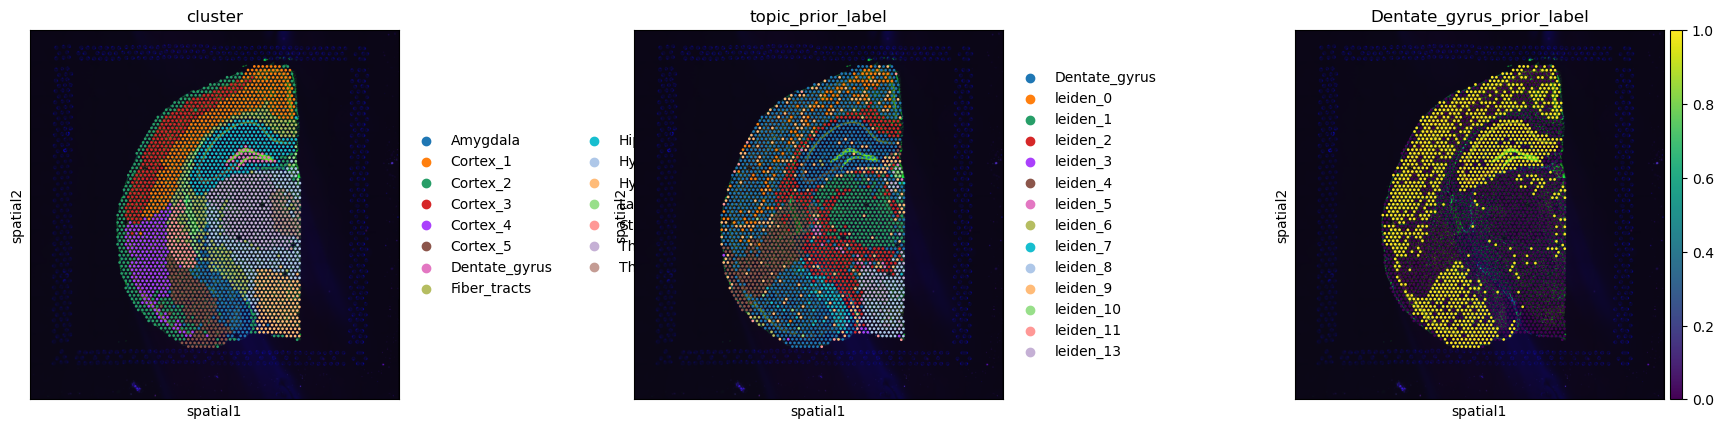

In [9]:
adata.obsm['topic_prior'] = compute_topic_prior(adata, marker_genes, temperature=0.8)
adata.obs['topic_prior_label'] = list(map(lambda i:id2cls[i], np.argmax(adata.obsm['topic_prior'], axis=1)))
adata.obs[f'{target_celltype}_prior_label'] = (adata.obs['topic_prior_label'] == target_celltype).astype(float)
if 'topic_prior_label_colors' in adata.uns:
    adata.uns.pop('topic_prior_label_colors')
    
sq.pl.spatial_scatter(adata, spatial_key='spatial', 
                      color=['cluster', 'topic_prior_label', f'{target_celltype}_prior_label']
                     )

> Evaluate the predicted probabilities of the target celltype and the assigned labels

In [10]:
def eval(adata, cls2id, exp_outdir, reg_seed_wt, reg_topic_prior, cls_scores, key_input):
    df_topic = pd.read_csv(os.path.join(exp_outdir, 'df_topic.csv'), index_col=0)
    df_topic.index = adata.obs_names
    id2cls = {v:k for k,v in cls2id.items()}
    adata.obs['topic'] =  [id2cls[idx] for idx in np.argmax(df_topic.values, axis=1).astype(int)]
    adata.obs[f'topic_0 {target_celltype}'] = (adata.obs.topic == target_celltype).astype(float)
    adata.obs[f'prob_{target_celltype}'] = adata.obs[f'topic_0 {target_celltype}'] * df_topic['topic_0'].values
    adata.obs['ground'] = (adata.obs.cluster == target_celltype).astype(float)
    sq.pl.spatial_scatter(adata, shape=None, color=['ground', f'prob_{target_celltype}', f'topic_0 {target_celltype}'])
    
    ars = adjusted_rand_score(adata.obs.ground, adata.obs[f'topic_0 {target_celltype}'])
    ami = adjusted_mutual_info_score(adata.obs.ground,adata.obs[f'topic_0 {target_celltype}'])
    auprc = average_precision_score(adata.obs.ground, adata.obs[f'prob_{target_celltype}'])
    auroc = roc_auc_score(adata.obs.ground, adata.obs[f'prob_{target_celltype}'])
    
    print("Adjusted Rand Score: ", ars)
    print("Adjusted Mutual Information Score: ", ami)
    print("AUPRC (SeedTopic): ", auprc)
    print("AUROC (SeedTopic): ", auroc)
    
    cls_scores.append({'key_input':key_input, 'top_seed_wt': reg_seed_wt, 'reg_topic_prior': reg_topic_prior, 
                       'ars': ars,
                       'ami': ami,
                       'auprc': auprc,
                       'auroc': auroc,
                      })

> For model fitting,
> - We suggest using 1.0 for reg_seed_wt, and start with 0.9 for reg_topic_prior
> - Sometimes searching in a range such as [0.0, 0.5, 0.8, 0.9, 0.95, 0.99] can help find a better reg_topic_prior

Start tfidf_pca
source /home/cqiao/.bashrc; micromamba activate seededntm; export CUBLAS_WORKSPACE_CONFIG=:4096:8; infer_seededntm  --wt_fusion_top_seed 1.0 --condition_feat_path ./topic_seeds_Dentate_gyrus --batch_size 8192 --adata_h5ad_path ./exp_Dentate_gyrus_result/seededntm_adata_input.h5ad --key_input tfidf_pca --key_count_out rna_count --num_topics 15 --exp_outdir ./exp_Dentate_gyrus_result/SeedNTM_input_tfidf_pca_output_rna_seedWt1.0_priorWt0.9 --key_topic_prior topic_prior --reg_topic_prior 0.9  


2026-02-02 23:15:47,212 - seededntm.main - INFO - Input parameters: Namespace(adata_h5ad_path='./exp_Dentate_gyrus_result/seededntm_adata_input.h5ad', condition_feat_path='./topic_seeds_Dentate_gyrus', key_input='tfidf_pca', key_count_out='rna_count', key_normal_out=None, key_obs_batch_label=None, key_topic_prior='topic_prior', num_topics=15, exp_outdir='./exp_Dentate_gyrus_result/SeedNTM_input_tfidf_pca_output_rna_seedWt1.0_priorWt0.9', random_seed=0, num_epochs=800, batch_size=8192, learning_rate=0.01, clip_norm=1.0, clamp_logvar_max=None, model_hid_dim=64, wt_fusion_top_seed=1.0, reg_topic_prior=0.9, scale_normal_feat=0.0, device='auto', use_nb_obs=True, use_multinomial_obs=False, early_stop=None, early_stop_tolerance=20, early_stop_minimum_steps=100)
2026-02-02 23:15:47,391 - seededntm.main - INFO - Reading adata...
2026-02-02 23:15:47,799 - seededntm.main - INFO - Output Count data key is: rna_count
2026-02-02 23:15:47,799 - seededntm.main - INFO - Processing experiment data ...
2

Namespace(adata_h5ad_path='./exp_Dentate_gyrus_result/seededntm_adata_input.h5ad', condition_feat_path='./topic_seeds_Dentate_gyrus', key_input='tfidf_pca', key_count_out='rna_count', key_normal_out=None, key_obs_batch_label=None, key_topic_prior='topic_prior', num_topics=15, exp_outdir='./exp_Dentate_gyrus_result/SeedNTM_input_tfidf_pca_output_rna_seedWt1.0_priorWt0.9', random_seed=0, num_epochs=800, batch_size=8192, learning_rate=0.01, clip_norm=1.0, clamp_logvar_max=None, model_hid_dim=64, wt_fusion_top_seed=1.0, reg_topic_prior=0.9, scale_normal_feat=0.0, device='auto', use_nb_obs=True, use_multinomial_obs=False, early_stop=None, early_stop_tolerance=20, early_stop_minimum_steps=100)


Epoch loss: total(27.5737)  elbo(257.8996)  topReg(1.9819): 100%|██████████| 800/800 [01:43<00:00,  7.71it/s] 
2026-02-02 23:17:39,957 - seededntm.main - INFO - Finished model fitting, please check output in ./exp_Dentate_gyrus_result/SeedNTM_input_tfidf_pca_output_rna_seedWt1.0_priorWt0.9


Adjusted Rand Score:  0.6045176134087499
Adjusted Mutual Information Score:  0.49403573948766105
AUPRC (SeedTopic):  0.8779204141101817
AUROC (SeedTopic):  0.997574121352623
Is successful: True


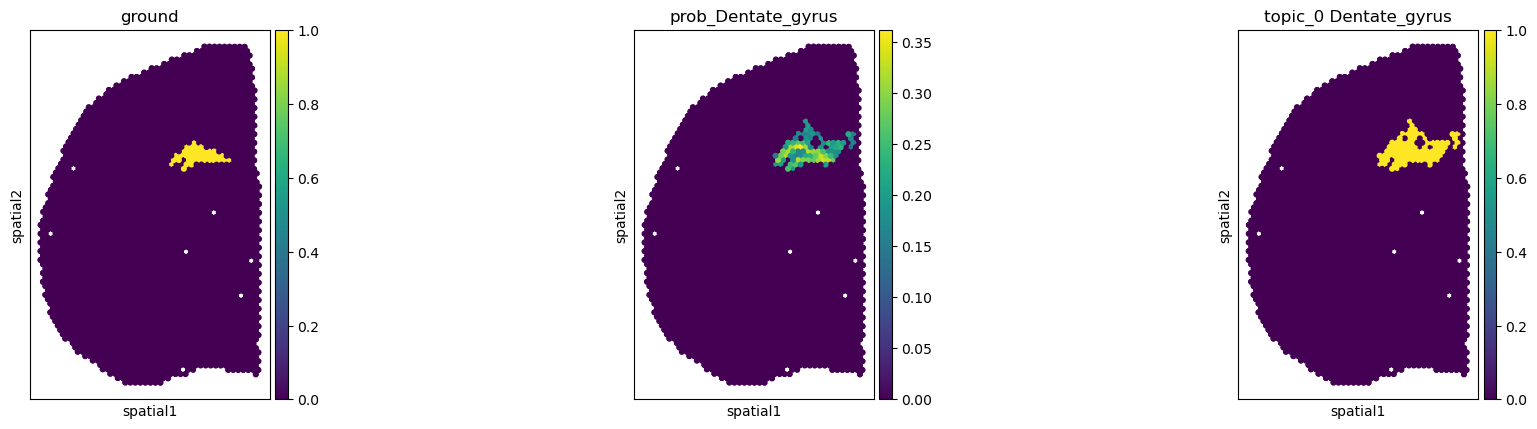

In [11]:
exp_root = f'./exp_{target_celltype}_result'
if not os.path.exists(exp_root):
    os.makedirs(exp_root, exist_ok=True)
adata_path = os.path.join(exp_root, 'seededntm_adata_input.h5ad')
adata.write_h5ad(adata_path)
count_out = 'rna_count'
key_topic_prior = 'topic_prior'

K = len(marker_genes)
reg_seed_wts = [1.0] 
reg_topic_priors = [0.9]

cls_scores = []
for key_input in [
                  'tfidf_pca',
                 ]:
    for reg_seed_wt in reg_seed_wts:
        for reg_topic_prior in reg_topic_priors:
            print(f'Start {key_input}')
            exp_string = f"SeedNTM_input_{key_input}_output_rna_seedWt{reg_seed_wt}_priorWt{reg_topic_prior}"
            exp_outdir = os.path.join(exp_root,
                                      exp_string
                                 )
    
            fitted = False
            cmd = ( f'source /home/cqiao/.bashrc; micromamba activate seededntm; export CUBLAS_WORKSPACE_CONFIG=:4096:8; ' +  
                        f'infer_seededntm  --wt_fusion_top_seed {reg_seed_wt} ' +
                        f'--condition_feat_path {TARGET_TOPIC_SEEDS_PATH} --batch_size 8192 --adata_h5ad_path {adata_path} ' +
                        f'--key_input {key_input} --key_count_out {count_out} --num_topics {K} --exp_outdir {exp_outdir} ' + 
                        f'--key_topic_prior {key_topic_prior} --reg_topic_prior {reg_topic_prior}  ')

            print(cmd)
    
            if call(cmd, shell=True) == 0:
                fitted = True
                eval(adata, cls2id, exp_outdir, reg_seed_wt, reg_topic_prior, cls_scores, key_input)
                
            print(f'Is successful: {fitted}')

### 